In [2]:
import numpy as np
import pandas as pd
import itertools 
import keras
from keras import layers
from keras.layers import Conv2D, Input, Dense, MaxPool2D,BatchNormalization,Flatten,ZeroPadding2D,Activation,Dropout
from keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [0]:
data = pd.read_csv('/content/drive/My Drive/data/FER_preprocessed.csv')
datapoints = data['pixels'].tolist()

In [0]:
width, height = 48, 48
X = []
for xseq in datapoints:
    x = [int(xp) for xp in xseq.split(' ')]
    x = np.asarray(x).reshape(width, height)
    X.append(x.astype('float64'))

In [0]:
y = pd.get_dummies(data['emotion']).to_numpy()
x = X
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

Define the model with input as input_shape i.e the shape of image


In [0]:
def classifierModel(input_shape):
  X_input = Input(input_shape)
  '''
  Layer 1
  '''
  X = Conv2D(64,(7,7),strides=(2,2),name = 'conv2')(X_input)
  X = Activation('relu')(X)
  X = MaxPool2D((3,3),strides=(2,2),name='max_pool2')(X)
  X = BatchNormalization()(X)

  '''
  Layer 2
  '''
  X1 = Conv2D(96,(1,1),name='conv4')(X)
  X1 = Activation('relu')(X1)
  X2 = MaxPool2D((3,3),strides=(1,1),name='max_pool3')(X)
  X3 = Conv2D(208,(3,3),name='conv5')(X1)
  X3 = Activation('relu')(X3)
  X4 = Conv2D(64,(1,1),name='conv6')(X2)
  X4 = Activation('relu')(X4)
  chunk_1 = keras.layers.concatenate([X3,X4],axis=3)
  '''
  Layer 3
  '''
  X5 = Conv2D(96,(1,1),name='conv7')(chunk_1)
  X5 = Activation('relu')(X5)
  X6 = MaxPool2D((3,3),strides=(1,1),name='max_pool4')(chunk_1)
  X7 = Conv2D(208, (3,3),name='conv8')(X5)
  X7 = Activation('relu')(X7)
  X8 = Conv2D(64,(1,1),name='conv9')(X6)
  X8 = Activation('relu')(X8)
  chunk_2 = keras.layers.concatenate([X7,X8],axis=3)
  '''
  Layer 4
  '''
  out = Flatten()(chunk_2)
  out = Dropout(0.5)(out)
  out = Dense(7,activation='softmax',use_bias=True)(out)
  model = Model(inputs=X_input,outputs=out,name='Second')
  return model

In [0]:
model1 = classifierModel((48,48,1))

In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model1.fit(X_train,y_train,epochs=10,batch_size=128,validation_data=(X_test,y_test),shuffle=True)

Train on 28709 samples, validate on 7178 samples
Epoch 1/10
28709/28709 [==============================] - 137s 5ms/step - loss: 1.6615 - accuracy: 0.3476 - val_loss: 1.6157 - val_accuracy: 0.4014
Epoch 2/10
28709/28709 [==============================] - 137s 5ms/step - loss: 1.4500 - accuracy: 0.4429 - val_loss: 1.4261 - val_accuracy: 0.4563
Epoch 3/10
28709/28709 [==============================] - 138s 5ms/step - loss: 1.3551 - accuracy: 0.4802 - val_loss: 1.3385 - val_accuracy: 0.4862
Epoch 4/10
28709/28709 [==============================] - 136s 5ms/step - loss: 1.2879 - accuracy: 0.5091 - val_loss: 1.3081 - val_accuracy: 0.5043
Epoch 5/10
28709/28709 [==============================] - 136s 5ms/step - loss: 1.2267 - accuracy: 0.5316 - val_loss: 1.2856 - val_accuracy: 0.5099
Epoch 6/10
28709/28709 [==============================] - 137s 5ms/step - loss: 1.1694 - accuracy: 0.5541 - val_loss: 1.2537 - val_accuracy: 0.5251
Epoch 7/10
28709/28709 [==============================] - 139s 

In [0]:
model1.summary()

Model: "Second"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 21, 21, 64)   3200        input_4[0][0]                    
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 21, 21, 64)   0           conv2[0][0]                      
__________________________________________________________________________________________________
max_pool2 (MaxPooling2D)        (None, 10, 10, 64)   0           activation_22[0][0]              
_____________________________________________________________________________________________

In [10]:
kf = KFold(n_splits=10)
kf.get_n_splits(x)
print(kf)
model2 = classifierModel((48,48,1))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for train_index,test_index in kf.split(x,np.asarray(data['emotion'])):
  #print("Running Fold", i+1, "/", n_folds)
  #print(train_index,test_index)
  X_train, X_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
  X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

  model2.fit(X_train,y_train,epochs=5,batch_size=128,validation_data=(X_test,y_test))

KFold(n_splits=10, random_state=None, shuffle=False)
Train on 32298 samples, validate on 3589 samples
Epoch 1/5
32298/32298 [==============================] - 139s 4ms/step - loss: 1.6303 - accuracy: 0.3579 - val_loss: 1.5923 - val_accuracy: 0.4015
Epoch 2/5
32298/32298 [==============================] - 139s 4ms/step - loss: 1.4306 - accuracy: 0.4488 - val_loss: 1.4043 - val_accuracy: 0.4614
Epoch 3/5
32298/32298 [==============================] - 138s 4ms/step - loss: 1.3367 - accuracy: 0.4897 - val_loss: 1.3234 - val_accuracy: 0.4893
Epoch 4/5
32298/32298 [==============================] - 141s 4ms/step - loss: 1.2685 - accuracy: 0.5161 - val_loss: 1.2810 - val_accuracy: 0.5024
Epoch 5/5
32298/32298 [==============================] - 138s 4ms/step - loss: 1.2125 - accuracy: 0.5403 - val_loss: 1.2821 - val_accuracy: 0.5138
Train on 32298 samples, validate on 3589 samples
Epoch 1/5
32298/32298 [==============================] - 138s 4ms/step - loss: 1.1730 - accuracy: 0.5554 - val_los

In [0]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,color = 'black')
    plt.yticks(tick_marks, classes,color = 'black')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12,color='black')
    plt.xlabel('Predicted label', fontsize=12,color='black')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

In [12]:
print(y_test)
ans = np.argmax(model2.predict(X_test),axis=-1)
y_test = np.argmax(y_test,axis=1)


[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


Normalized confusion matrix
[[0.91836735 0.         0.02653061 0.00612245 0.02653061 0.
  0.02244898]
 [0.03636364 0.85454545 0.05454545 0.         0.01818182 0.01818182
  0.01818182]
 [0.02083333 0.         0.92234848 0.01136364 0.02083333 0.00568182
  0.01893939]
 [0.00568828 0.         0.00568828 0.96131968 0.01023891 0.00455063
  0.01251422]
 [0.02020202 0.         0.01178451 0.01346801 0.93939394 0.0016835
  0.01346801]
 [0.00961538 0.         0.01682692 0.01201923 0.00961538 0.94951923
  0.00240385]
 [0.00638978 0.         0.00638978 0.00638978 0.01597444 0.00159744
  0.96325879]]


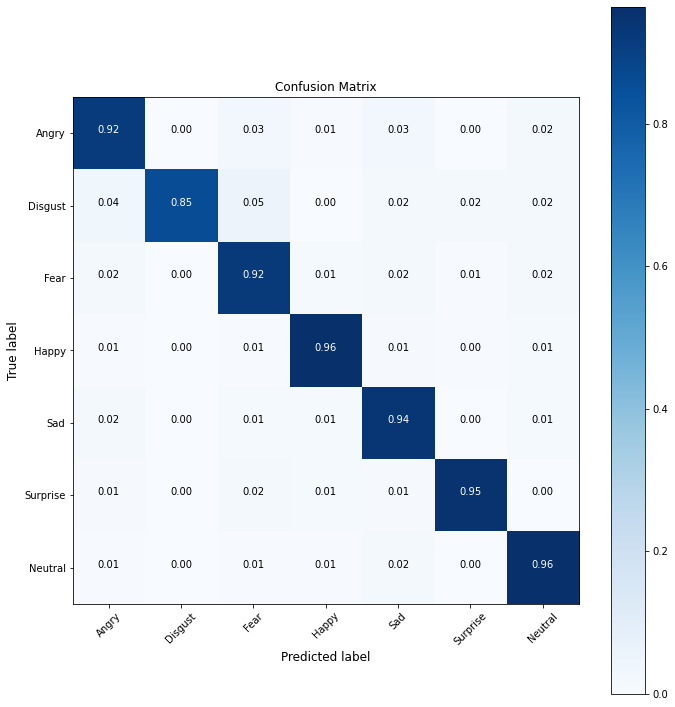

In [13]:
matrix = confusion_matrix(y_test,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')

In [0]:
for key in model1.history.history.keys():
    print(key)

val_loss
val_accuracy
loss
accuracy


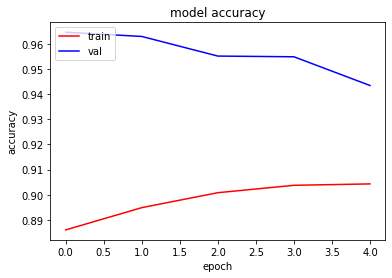

In [14]:
plt.plot(model2.history.history['accuracy'],'r')
plt.plot(model2.history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()